In [26]:
import numpy as np
from typing import Callable

np_function = Callable[[np.ndarray], np.ndarray]
def undefined(conditions: list[np_function], condition_funcs: list[np_function]):
    assert len(conditions) == len(condition_funcs)
    def decorator(func: np_function):
        def wrapper(arr: np.ndarray):
            this_condition_funcs = condition_funcs
            this_conditions = conditions
            # get masks
            cond_masks = [condition(arr) for condition in this_conditions]
            # remove conditions that are not met
            this_condition_funcs = [condition_func for condition_func, cond_mask in zip(this_condition_funcs, cond_masks) if np.any(cond_mask)]
            if len(this_condition_funcs) == 0:
                return func(arr)

            cond_masks = [cond_mask for cond_mask in cond_masks if np.any(cond_mask)]
            cond_masks = np.stack(cond_masks, axis=0)
            
            uncond_mask = ~np.logical_or.reduce(cond_masks, axis=0)
            # compute conditional values
            cond_outs = [condition_func(arr[cond_mask]) for condition_func, cond_mask in zip(this_condition_funcs, cond_masks)]
            # compute unconditional values
            uncond_out = func(arr[uncond_mask])
            # combine conditional and unconditional values
            assert all([cond_out.shape[0] == cond_masks[i].sum() for i, cond_out in enumerate(cond_outs)])
            assert uncond_out.shape[0] == uncond_mask.sum()
            assert all([cond_out.shape[1:] == uncond_out.shape[1:] for cond_out in cond_outs])
            out = np.empty((arr.shape[0],) + uncond_out.shape[1:], dtype=uncond_out.dtype)
            out[uncond_mask] = uncond_out
            for cond_out, cond_mask in zip(cond_outs, cond_masks):
                out[cond_mask] = cond_out
            return out
                
        return wrapper
    return decorator

@undefined(
    [lambda x: x == 0, lambda x: x == 1],
    [lambda x: np.ones_like(x), lambda x: np.full_like(x, 1/2)]
)
def f(d):
    return (d * np.log(d) - (d-1)) / (d - 1)**2

@undefined(
    [lambda x: x == 0, lambda x: x == 1],
    [lambda x: np.full_like(x, -np.inf), lambda x: np.full_like(x, -1/6)]
)
def f_prime(d):
    return - ((d + 1) * f(d) - 1) / (d * (d-1))

@undefined(
    [lambda x: x == 0, lambda x: x == 1],
    [lambda x: np.full_like(x, np.inf), lambda x: np.full_like(x, 1/6)]
)
def f_prime2(d):
    return - ((d - 1) * f(d) - 3 * (d + 1) * f(d) + 3) / (d * (d-1) ** 2)


In [29]:
import plotly.express as px
import numpy as np
import pandas as pd

d = np.linspace(0.0, 10, 101)
data = pd.DataFrame({"d": d, "f": f(d), "f'": f_prime(d), "f''": f_prime2(d)})
display(data.head())
fig = px.line(data, x="d", y=["f", "f'", "f''"], labels={"x": "d", "y": "Value", "variable": "Derivatives"})
fig.show()

,d,f,f',f''
0,0.0,1.000000,-inf,inf
1,0.1,0.826841,-1.005272,5.836218
2,0.2,0.747051,-0.647120,2.242366
3,0.3,0.691445,-0.481530,1.228898
4,0.4,0.648566,-0.383366,0.785528


In [ ]:
from ipywidgets import interact
import numpy as np

# What does n f(d) along directions
# arctan(n/d) - pi to arctan(-(n-1) / d)
# I'll make an interactive plot of this where I can choose the angle.

import plotly.graph_objects as go
def angle_restriction(n, d_val):
    return (np.degrees(np.arctan(n/d_val) - np.pi), np.degrees(np.arctan(-(n-1)/d_val)))

def plot_n_f_d(n_val=10, d_val=2, angle=angle_restriction(10, 2)[0]):
    min_angle, max_angle = angle_restriction(n_val, d_val)
    if angle < min_angle or angle > max_angle:
        print(f"Angle must be between {min_angle:.2f} and {max_angle:.2f} degrees for n={n_val} and d={d_val}")
        angle = min_angle if angle < min_angle else max_angle
    
    t = np.linspace(-100, 100, 4000)
    angle_rad = np.radians(angle)
    d_t = d_val + t * np.cos(angle_rad)
    n_t = n_val + t * np.sin(angle_rad)
    # restrict where d_t >= 0 and n_t >= 1
    valid_mask = (d_t >= 0) & (n_t >= 1)
    t = t[valid_mask]
    d_t = d_t[valid_mask]
    n_t = n_t[valid_mask]

    y = n_t * f(d_t)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=t, y=y, mode='lines', name='n*f(d)'))
    fig.add_trace(go.Scatter(x=[0], y=[n_val * f(d_val)], mode='markers', marker=dict(size=10, symbol='star', color='red'), name='t=0'))
    fig.update_layout(title=f'n*f(d) along direction {angle} degrees',
                      xaxis_title='t',
                      yaxis_title='n*f(d)')
    fig.show()

interact(plot_n_f_d, 
         n_val=(1, 100, 1), 
         d_val=(0, 10, 0.1), 
         angle=(-180, 180, .1))

interactive(children=(IntSlider(value=10, description='n_val', min=1), FloatSlider(value=2.0, description='d_v…

<function __main__.plot_n_f_d(n_val=10, d_val=2, angle=np.float64(-101.3099324740202))>

In [72]:
# The characteristic curves of our PDE solution
# The characteristic equations are given by
# dx/dt = x(x-1)
# dy/dt = (y - (x+1))(x+1)
# dz/dt = y - (x+1)
# Since A < 0, range of t should be
# -inf < t < log(-1/A)
def t_upper_bound(x0):
    A = (1 - x0) / x0
    return np.log(-1/A)

def x(t, x0):
    A = (1 - x0) / x0
    assert np.all(t < np.log(-1/A))
    return 1 / (1 + A * np.exp(t))

def y(x_val, x0, y0):
    A = (1 - x0) / x0
    B = y0 / x0 - 2 + (x0-1)**2 / x0 **2 * np.log(x0)
    y_val = ((x_val - 1) **2 / x_val) * (B / (A ** 2) - np.log((1 - x_val)  / A)) + 2 * x_val

    return y_val

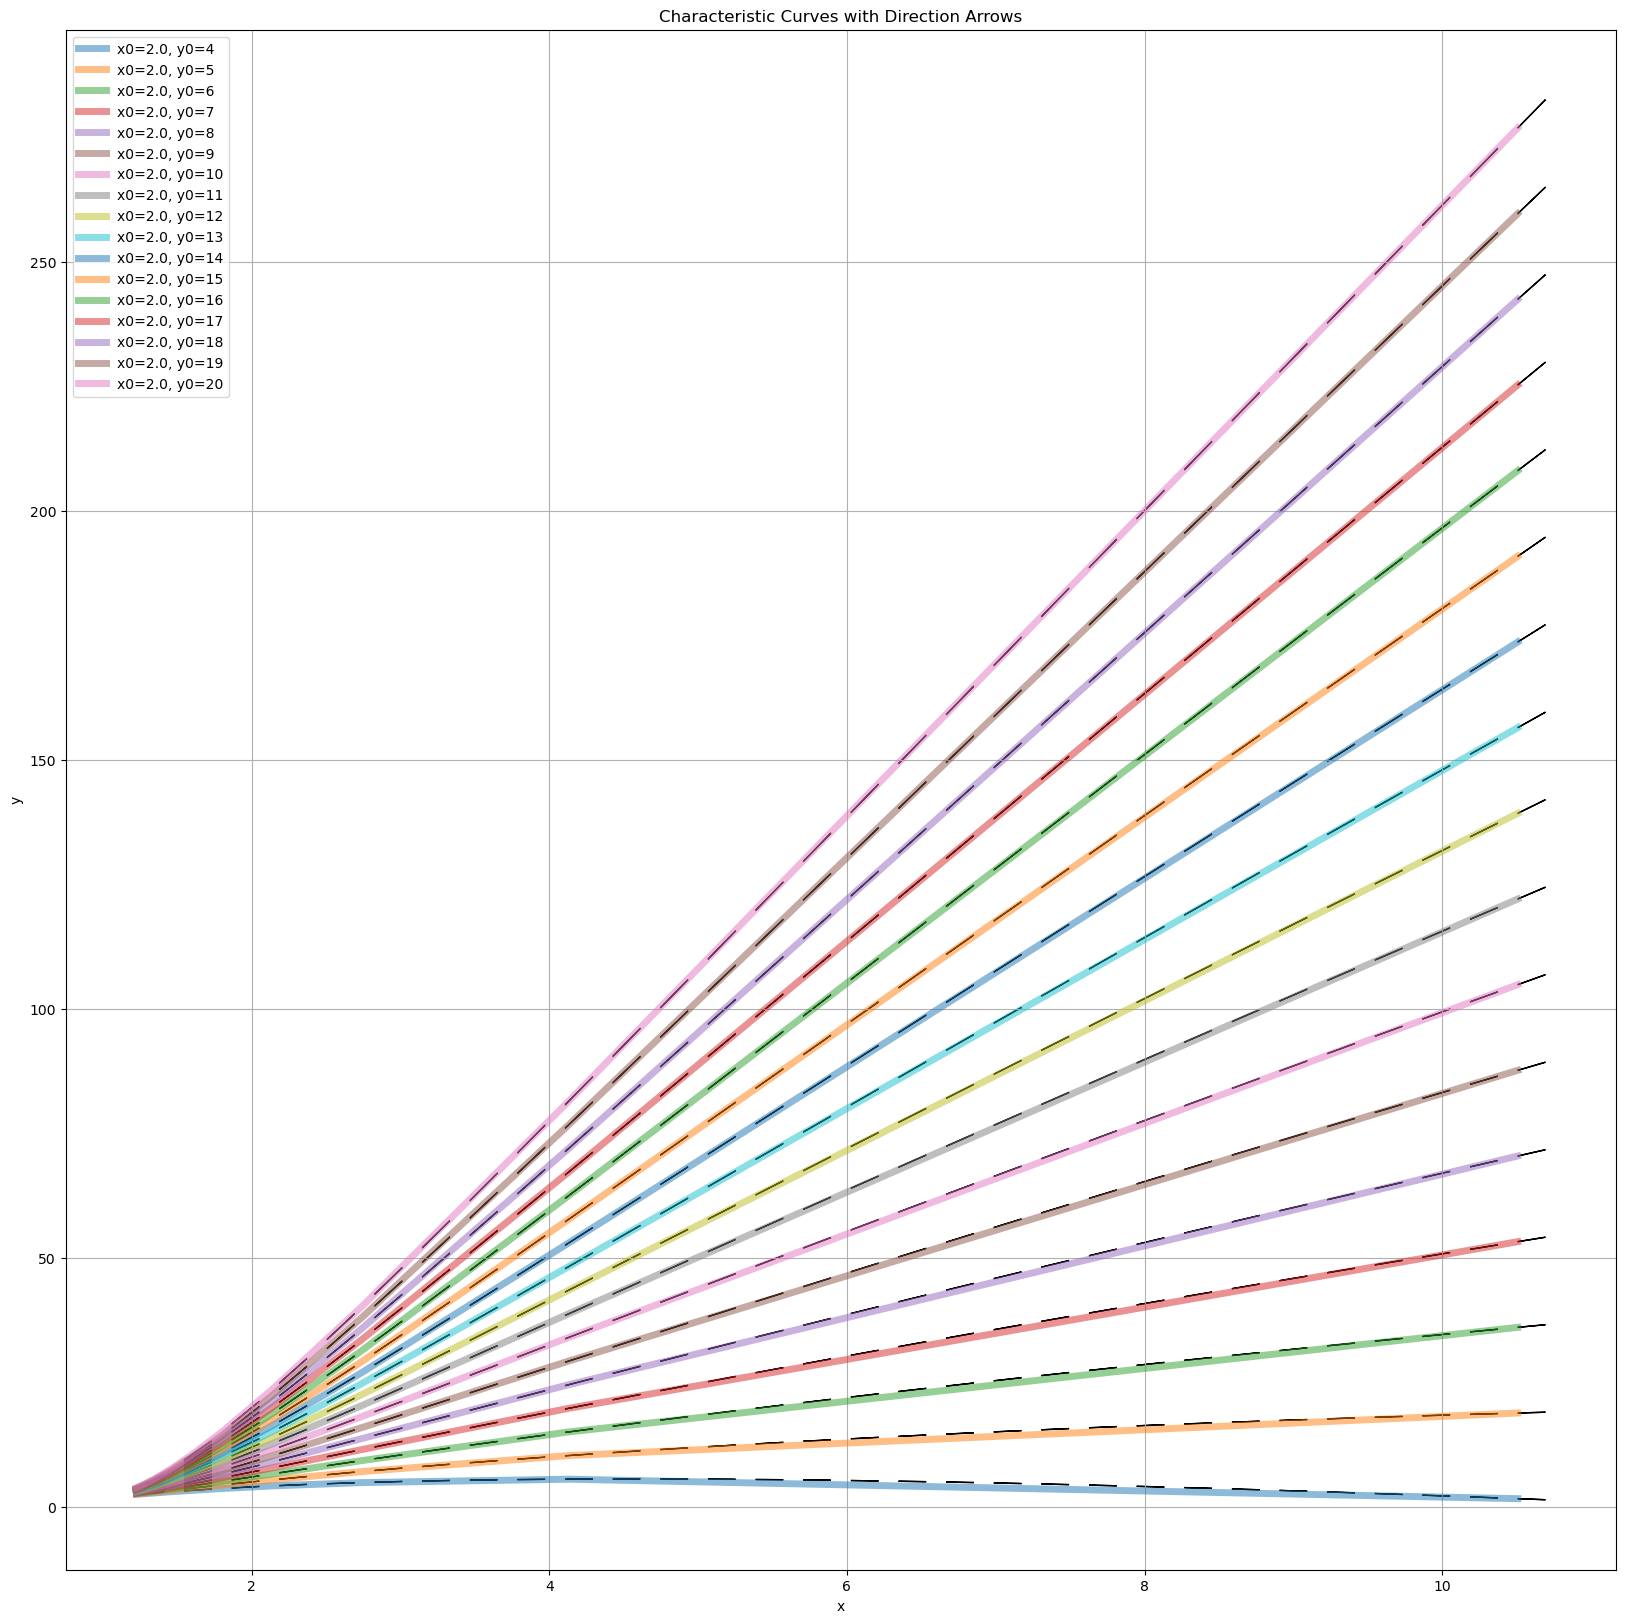

In [110]:
import matplotlib.pyplot as plt

# Define the characteristic equations
def dx_dt(x):
    return x * (x - 1)

def dy_dt(x, y):
    return (y - (x + 1)) * (x + 1)

def dz_dt(y, x):
    return y - (x + 1)

# Define the initial conditions
x0 = [2.0]
y0 = np.arange(4, 21)

# Plot the characteristic curves using x(t) and y(t)
plt.figure(figsize=(20, 20))
for x_init in x0:
    for y_init in y0:
        # t = np.linspace(-1, t_upper_bound(x_init)- 1e-5, 100)
        t = np.linspace(-1, t_upper_bound(x_init) - 0.1, 10)

        x_vals = x(t, x_init)
        y_vals = y(x_vals, x_init, y_init)
        plt.plot(x_vals, y_vals, label=f'x0={x_init}, y0={y_init}', alpha=0.5, linewidth=5.0)

        x_linspace = np.linspace(np.min(x_vals), np.max(x_vals),30)
        y_linspace = y(x_linspace, x_init, y_init)
        dx_dt_linspace = dx_dt(x_linspace)
        dy_dt_linspace = dy_dt(x_linspace, y_linspace)
        normalize_factor = dx_dt_linspace / ((np.max(x_linspace) - np.min(x_linspace)) / 50)
        for i in range(len(x_linspace)):
            plt.arrow(x_linspace[i], y_linspace[i], dx_dt_linspace[i] / normalize_factor[i], dy_dt_linspace[i] / normalize_factor[i], head_width=0.0, length_includes_head=True, fc='k', ec='k')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Characteristic Curves with Direction Arrows')
plt.legend()
plt.grid(True)
plt.show()